In [7]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Loading 2002, 2012 dta files

In [8]:
with pd.io.stata.StataReader("../dta files/2012.dta", convert_categoricals=True) as rdr:
    cols = [c for c in rdr.variable_labels().keys() if c not in {"ISCO88", "SPISCO88"}]
    df_2012 = rdr.read(columns=cols)

with pd.io.stata.StataReader("../dta files/2002.dta", convert_categoricals=True) as rdr:
    cols = [c for c in rdr.variable_labels().keys() if c not in ["v241","v247"]]
    df_2002 = rdr.read(columns=cols)

df_2022 = pd.read_stata("../dta files/2022.dta")


In [113]:
df_2002_clean = pd.read_csv("../clean_csv/2002_clean.csv")
df_2012_clean = pd.read_csv("../clean_csv/2012_clean.csv")
df_2022_clean = pd.read_csv("../clean_csv/2022_clean.csv")

### Proper plot-1

In [9]:
def code_for_income_control_2012(x):
    if x is None:
        return None
    elif x == 'I manage all and give partner his share':
        return "Financial control is with the respondent"
    elif x == 'Partner manages all and gives me my share':
        return "Financial control is with the partner"
    elif x in ['We pool all money, each take out', 'We pool some money, rest separate']:
        return "Financial control is shared"
    elif x == 'We each keep own money separate':
        return "Financial control is separate"
    else:
        return None


In [10]:
def code_for_income_control_2022(x):
    if x is None:
        return None
    elif x == '1. I manage all and give partner his share':
        return "Financial control is with the respondent"
    elif x == '2. Partner manages all and gives me my share':
        return "Financial control is with the partner"
    elif x in ['3. We pool all money, each take out', '4. We pool some money, rest separate']:
        return "Financial control is shared"
    elif x == '5. We each keep own money separate':
        return "Financial control is separate"
    else:
        return None


In [11]:
def code_for_income_control_2002(x):
    if x is None:
        return None
    elif x == 'I manage all the money':
        return "Financial control is with the respondent"
    elif x == "Spouse,partner manages money":
        return "Financial control is with the partner"
    elif x in ['We pool all the money', 'We pool some money']:
        return "Financial control is shared"
    elif x == 'Each keep own money separate':
        return "Financial control is separate"
    else:
        return None


In [12]:
df_2002["code_income_control"] = df_2002["v29"].apply(code_for_income_control_2002)
df_2012["code_income_control"] = df_2012["V41"].apply(code_for_income_control_2012)
df_2022["code_income_control"] = df_2022["v38"].apply(code_for_income_control_2022)

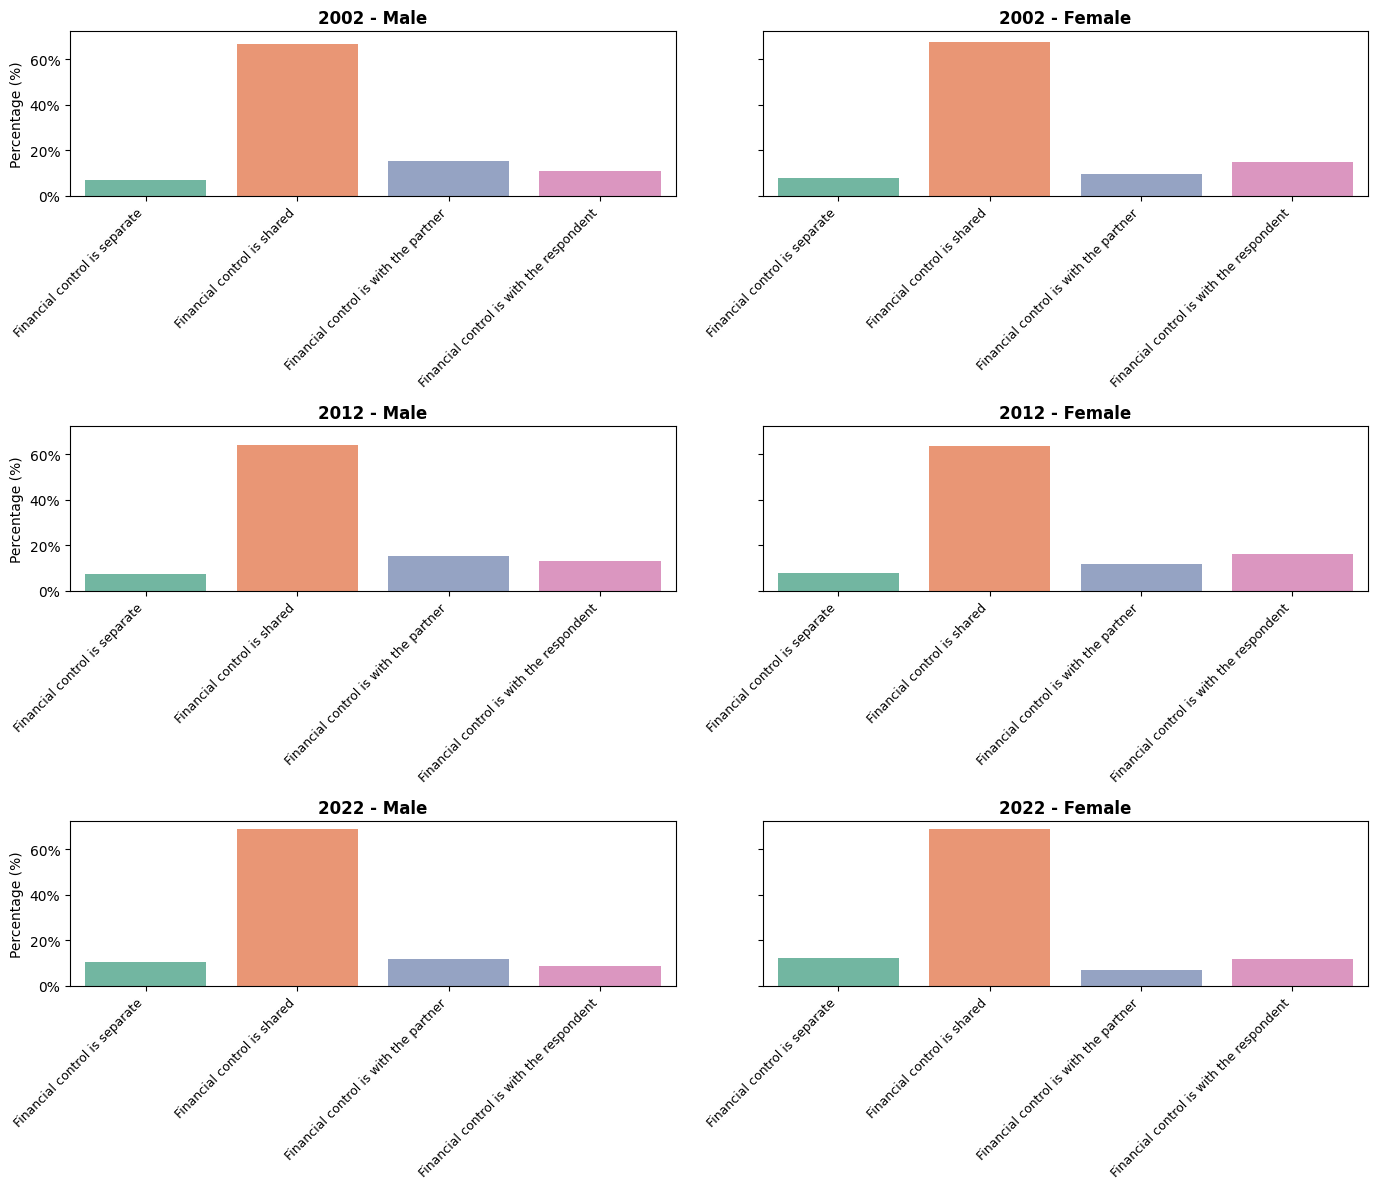

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharey=True)

years = [2002, 2012, 2022]
dfs = [df_2002, df_2012, df_2022]
sex_labels = ["Male", "Female"]
sex_codes_2022 = ["1. Male", "2. Female"]

for row, (year, df) in enumerate(zip(years, dfs)):
    for col, sex in enumerate(sex_labels):
        ax = axes[row, col]
        
        if year == 2002:
            sub = df[(df["v200"] == sex) & (df["v202"] == "Marr,liv as mar")]
        elif year == 2012:
            sub = df[(df["SEX"] == sex) & (df["MARITAL"] == "Married")]
        else:  # 2022
            sub = df[(df["SEX"] == sex_codes_2022[col]) & (df["MARITAL"] == '1. Married')]
        
        vc = sub["code_income_control"].value_counts(normalize=True) * 100
        vc = vc.sort_index()
        
        sns.barplot(x=vc.index, y=vc.values, ax=ax, palette="Set2")
        ax.set_title(f"{year} - {sex}", fontsize=12, fontweight='bold')
        ax.set_ylabel("Percentage (%)" if col == 0 else "")
        ax.set_xlabel("")
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()

In [14]:
def fix_hh_hours(x):
    invalid_options=[
        "Don't know, BG: can't choose",
        'No answer, CA: no answer, refused',
        "Don't know, BG: can't choose, KR: don't know, refused",
        'No answer, CA: no answer, refused',
        'NAP, no partner (3 (AR,AT,BE,CH,CL,ES,IS,KR,NL,NO,PL,SK,US:2,3; BG,CZ,PT:2,3,7;IL:3,7) in PARTLIV;TW:3-6 in MARITAL)',
        "-9. No answer; HR, IS: DK/NA; ES, HU: Can't Ch/NA; LT: NA/DK/Hard to say; PL: Hard to say/NA; TW: Can't choose",
        "-9. No answer; HR, IS: DK/NA; ES, HU, TW: Can't Ch/NA; LT: NA/DK/Hard to say; PL: Hard to say/NA",
       '-4. NAP, no partn. or not liv. with part. (c.2,3,-7 PARTLIV; US: c.2 (if neither married nor cohabit. with partner), 3 PARTL'
                     ]
    if x in invalid_options:
        return None
    if isinstance(x, str):
        x = x.strip()
        if x.startswith("None") or x.startswith("0"):
            return 0
        elif x.startswith("95"):
            return 95
        elif x.startswith("1"):
            return 1
        elif x.startswith("2"):
            return 2
        elif x.startswith("3"):
            return 3
        else:
            return int(x)
    return x


df_2002['v36']=df_2002['v36'].apply(fix_hh_hours)
df_2002['v37']=df_2002['v37'].apply(fix_hh_hours)
df_2002["hh_bin"] = pd.cut(
    df_2002["v36"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0–20", "21–40", "41–60", "61–80", "81+"]
)
df_2002["spouse_hh_bin"] = pd.cut(
    df_2002["v37"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0–20", "21–40", "41–60", "61–80", "81+"]
)

df_2012['V37']=df_2012['V37'].apply(fix_hh_hours)
df_2012['V39']=df_2012['V39'].apply(fix_hh_hours)

df_2012["hh_bin"] = pd.cut(
    df_2012["V37"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0–20", "21–40", "41–60", "61–80", "81+"]
)
df_2012["spouse_hh_bin"] = pd.cut(
    df_2012["V39"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0–20", "21–40", "41–60", "61–80", "81+"]
)

df_2022['v34']=df_2022['v34'].apply(fix_hh_hours)
df_2022['v36']=df_2022['v36'].apply(fix_hh_hours)

df_2022["hh_bin"] = pd.cut(
    df_2022["v34"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0–20", "21–40", "41–60", "61–80", "81+"]
)
df_2022["spouse_hh_bin"] = pd.cut(
    df_2022["v36"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0–20", "21–40", "41–60", "61–80", "81+"]
)


In [15]:
df_2002.name = "df_2002"
df_2012.name = "df_2012"
df_2022.name = "df_2022"

In [16]:
years = [2002, 2012, 2022]
dfs = [df_2002, df_2012, df_2022]

results = []

for year, df in zip(years, dfs):
    if year == 2002:
        male = df[(df["v200"] == "Male") & (df["v202"] == "Marr,liv as mar")]
        female = df[(df["v200"] == "Female") & (df["v202"] == "Marr,liv as mar")]
    elif year == 2012:
        male = df[(df["SEX"] == "Male") & (df["MARITAL"] == "Married")]
        female = df[(df["SEX"] == "Female") & (df["MARITAL"] == "Married")]
    else:  # 2022
        male = df[(df["SEX"] == "1. Male") & (df["MARITAL"] == "1. Married")]
        female = df[(df["SEX"] == "2. Female") & (df["MARITAL"] == "1. Married")]
    

    # keep only single-person control
    male_single = male[male["code_income_control"].isin(["Financial control is with the partner", "Financial control is with the respondent"])]
    # print(len(male_single))
    female_single = female[female["code_income_control"].isin(["Financial control is with the partner", "Financial control is with the respondent"])]

    results.append({
        "Year": year,
        "Male share": len(male_single) / (len(male_single) + len(female_single)) * 100,
        "Female share": len(female_single) / (len(male_single) + len(female_single)) * 100
    })

res_df = pd.DataFrame(results)
res_df

,Year,Male share,Female share
0,2002,48.359422,51.640578
1,2012,49.449244,50.550756
2,2022,50.747664,49.252336


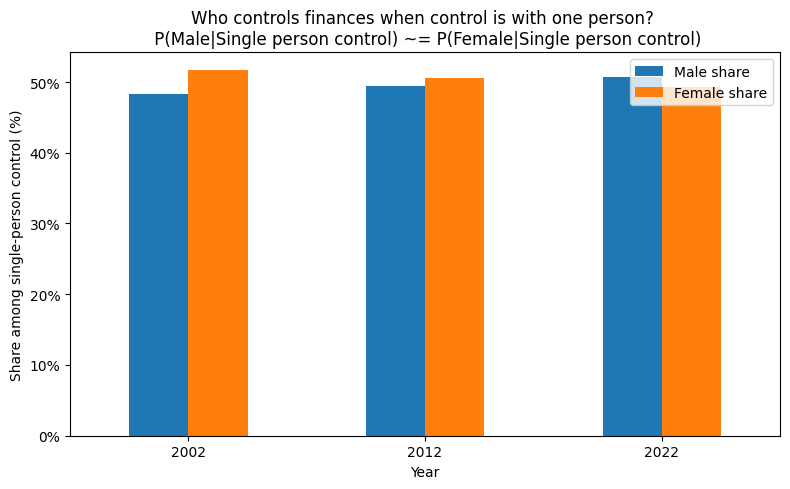

In [17]:
res_df.set_index("Year")[["Male share", "Female share"]].plot(
    kind="bar",
    figsize=(8, 5)
)

plt.ylabel("Share among single-person control (%)")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Who controls finances when control is with one person? \n P(Male|Single person control) ~= P(Female|Single person control)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [18]:
df_2012[df_2012["code_income_control"].isin(["Financial control is with the partner"])][["V65"]].value_counts()
df_2012[df_2012["code_income_control"].isin(["Financial control is with the respondent"])][["DEGREE"]].value_counts()

# No co-relation between education and financial control

DEGREE                                                                                                   
Lower secondary (secondary completed does not allow entry to university: obligatory school)                  1286
Upper secondary (programs that allows entry to university                                                    1284
Primary school (elementary school)                                                                            767
Lower level tertiary, first stage (also technical schools at a tertiary level)                                654
Post secondary, non-tertiary (other upper secondary programs toward labour market or technical formation)     623
No formal education                                                                                           452
Upper level tertiary (Master, Dr.)                                                                            227
No answer, CH: don't know                                                                       

In [19]:
df_2012[df_2012["code_income_control"].isin(["Financial control is with the partner"])][["MAINSTAT"]].value_counts() #MAINSTAT
# df_2012[df_2012["code_income_control"].isin(["Financial control is with the respondent"])][["MAINSTAT"]].value_counts() #SPMAINST

MAINSTAT                                                  
In paid work                                                  2349
Domestic work                                                 1025
Retired                                                        730
Unemployed and looking for a job, HR: incl never had a job     367
Other                                                          199
Permanently sick or disabled                                   109
In education                                                    67
No answer                                                       54
Apprentice or trainee                                           10
In compulsory military service or community service              0
Name: count, dtype: int64

In [20]:
df_2012[(df_2012["MAINSTAT"] == "Unemployed and looking for a job, HR: incl never had a job") & (df_2012["SEX"] == "Male")]["code_income_control"].value_counts()

code_income_control
Financial control is shared                 500
Financial control is with the partner       157
Financial control is with the respondent    144
Financial control is separate                70
Name: count, dtype: int64

In [21]:
def code_for_higher_income_2012(x):
    if x == 'NAP, no partner (3 (AT,BE,CH,CL,ES,IN,IS,KR,NL,NO,PL,SK,US:2,3;AR,BG,CZ,PT:2,3,7;IL:3,7) in PARTLIV;TW:3-6 in MARITAL)':
        return None
    elif x in ["I have a much higher income", "I have a higher income	"]:
        return "Respondent has higher income"
    elif x in ['My spouse/ partner has a higher income', 'My spouse/ partner has a much higher income']:
        return "Partner has higher income"
    elif x == "I have no income":
        return "Respondent has no income"
    elif x == 'My spouse/ partner has no income':
        return "Partner has no income"
    else:
        return None

def code_for_higher_income_2002(x):
    if x is None:
        return None
    elif x in ["I have much higher income", "I have a higher income"]:
        return "Respondent has higher income"
    elif x in ["Spouse has higher income", "Spouse has much higher income"]:
        return "Partner has higher income"
    elif x == "I have no income":
        return "Respondent has no income"
    elif x == "Spouse has no income":
        return "Partner has no income"
    elif x == "We have about the same income":
        return "Same income"
    else:
        return None

In [22]:
df_2012["code_higher_income"] = df_2012["V50"].apply(code_for_higher_income_2012)
df_2002["code_higher_income"] = df_2002["v43"].apply(code_for_higher_income_2002)

The below cell tries to identify if there is a relation between higher income and financial control. 
We saw that the financial control is shared in most of the cases, so the hypothesis is that men believe in equality and share financial control. 
We also want to check if income has any effect on financial control. Men are generally paid higher, so what if in cases where the financial control is not shared, it is because of higher income. 
If that is also not true, i.e. having high income does not have an effect on financial control, then men believe in equality in financial control. 

In [23]:
bad = "NAP, no partner (3 (AT,BE,CH,CL,ES,IN,IS,KR,NL,NO,PL,SK,US:2,3;AR,BG,CZ,PT:2,3,7;IL:3,7) in PARTLIV;TW:3-6 in MARITAL)"
bad_v41 = {
    "Don't know, KR: don't know, refused",
    "No answer, CA: no answer, refused",
}

base = df_2012[
    (df_2012["MARITAL"] == "Married")
    & (df_2012["SEX"] == "Male")
    & (df_2012["V50"] != bad)
    & (~df_2012["V41"].isin(bad_v41))
    & (df_2012["V41"] != bad)
].copy()

base["V50"] = base["V50"].cat.remove_unused_categories()
base["V41"] = base["V41"].cat.remove_unused_categories()

tab = (
    base.groupby("code_higher_income")["code_income_control"]
        .value_counts()
        .unstack(fill_value=0)
)
tab

code_income_control,Financial control is separate,Financial control is shared,Financial control is with the partner,Financial control is with the respondent
code_higher_income,,,,
Partner has higher income,164,1112,284,106
Partner has no income,66,1002,485,693
Respondent has higher income,312,2489,606,594
Respondent has no income,12,162,97,48


In [24]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(tab)

print(f"Chi-square: {chi2:.2f}")
print(f"p-value: {p:.4f}")


Chi-square: 616.38
p-value: 0.0000


In [25]:
tab_pct = tab.div(tab.sum(axis=1), axis=0) * 100
tab_pct.round(1)

code_income_control,Financial control is separate,Financial control is shared,Financial control is with the partner,Financial control is with the respondent
code_higher_income,,,,
Partner has higher income,9.8,66.7,17.0,6.4
Partner has no income,2.9,44.6,21.6,30.9
Respondent has higher income,7.8,62.2,15.1,14.8
Respondent has no income,3.8,50.8,30.4,15.0


## Conclusion of testing whether men believe in visible equality (income and financial control)

Most of the times, financial control is shared, but income sways the financial control only modestly and is with the partner who earns. Even in cases, when men earn higher, financial control is shared. 

## To Do - Make the below for all three years

In [26]:
# Plot for mean household work_hours by gender

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pycountry

GENDER_COL = "SEX"
MALE_VALUE = "Male"
FEMALE_VALUE = "Female"

# 1) Clean + extract ISO-2
df_clean = df_2012.dropna(subset=["V37", "V4", GENDER_COL]).copy()
df_clean["V37"] = pd.to_numeric(df_clean["V37"], errors="coerce")
df_clean = df_clean.dropna(subset=["V37"])

df_clean["iso2"] = df_clean["V4"].str.split("-", n=1).str[0].str.strip()

# 2) Convert ISO-2 -> ISO-3
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except Exception:
        return None

df_clean["iso3"] = df_clean["iso2"].apply(iso2_to_iso3)
df_clean = df_clean.dropna(subset=["iso3"])

# 3) Split male/female
df_male = df_clean[df_clean[GENDER_COL] == MALE_VALUE].copy()
df_female = df_clean[df_clean[GENDER_COL] == FEMALE_VALUE].copy()

# 4) Aggregate mean hours by country
country_mean_male = (
    df_male.groupby("iso3", as_index=False)["V37"]
    .mean()
    .rename(columns={"V37": "mean_hours"})
)

country_mean_female = (
    df_female.groupby("iso3", as_index=False)["V37"]
    .mean()
    .rename(columns={"V37": "mean_hours"})
)

# 5) Force SAME color scale for both plots
vmin = min(country_mean_male["mean_hours"].min(), country_mean_female["mean_hours"].min())
vmax = max(country_mean_male["mean_hours"].max(), country_mean_female["mean_hours"].max())

# 6) Create side-by-side subplots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "geo"}, {"type": "geo"}]],
    subplot_titles=("Male: Mean Household Work Hours", "Female: Mean Household Work Hours")
)

# Male choropleth
fig.add_trace(
    go.Choropleth(
        locations=country_mean_male["iso3"],
        z=country_mean_male["mean_hours"],
        colorscale="Viridis",
        zmin=vmin,
        zmax=vmax,
        colorbar=dict(title="Hours", x=0.46),
        name="Male"
    ),
    row=1, col=1
)

# Female choropleth
fig.add_trace(
    go.Choropleth(
        locations=country_mean_female["iso3"],
        z=country_mean_female["mean_hours"],
        colorscale="Viridis",
        zmin=vmin,
        zmax=vmax,
        colorbar=dict(title="Hours", x=1.02),
        name="Female"
    ),
    row=1, col=2
)

# Update layout
fig.update_geos(showframe=False, showcoastlines=True, projection_type="natural earth")
fig.update_layout(
    title_text="Mean Household Work Hours by Gender (2012)",
    height=600,
    width=1400
)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [32]:
def fix_work_hours(x):
    invalid_options=[
        '-9. No answer',
        "-8. Don't know",
        '-4. NAP (code 2 or 3 in WORK)',
        '-1. DK: Not available',
        '-9. No answer',
        "-8. Don't know",
        '-6. IL: Invalid answers',
        '-4. NAP (code -4, 2 or 3 in SPWORK)',
        'Refused; TW: time varies',
        "Don't know",
        'No answer',
        'TW: time varies',
        'NAP (code 0,2,3 (AR,VE: 0,3) in SPWORK); not available: BG,GB',
        'NAP (code 2,3 (AR,DK,VE: code 3) in WORK)',
                     ]
    if x in invalid_options:
        return None
    if isinstance(x, str):
        x = x.strip()
        if x.startswith("None") or x.startswith("0"):
            return 0
        elif x.startswith("96"):
            return 96
        elif x.startswith("89"):
            return 89
        elif x.startswith("10"):
            return 10
        elif x.startswith("50"):
            return 50
        elif x.startswith("15"):
            return 15
        elif x.startswith("30"):
            return 30
        elif x.startswith("40"):
            return 40
        elif x.startswith("5"):
            return 5
        elif x.startswith("1"):
            return 1
        elif x.startswith("One"):
            return 1
        elif x.startswith("20"):
            return 20
        elif x.startswith("2"):
            return 2
        elif x.startswith("3"):
            return 3
        else:
            return int(x)
    return x


In [33]:
df_2002["v71"] = df_2002["v71"].apply(fix_work_hours)
df_2002["v240"] = df_2002["v240"].apply(fix_work_hours)

df_2012["WRKHRS"] = df_2012["WRKHRS"].apply(fix_work_hours)
df_2012["SPWRKHRS"] = df_2012["SPWRKHRS"].apply(fix_work_hours)

df_2022["WRKHRS"] = df_2022["WRKHRS"].apply(fix_work_hours)
df_2022["SPWRKHRS"] = df_2022["SPWRKHRS"].apply(fix_work_hours)

In [34]:
df_2002_egal = df_2002[["v4", "v5", "v6", "v7", "v8", "v11"]]
df_2012_egal = df_2012[["V5", "V6", "V7", "V8", "V9", "V11"]]
df_2022_egal = df_2022[["v1", "v2", "v3", "v4", "v5", "v6"]]

In [35]:
df_2002_egal.name = "df_2002_egal"
df_2012_egal.name = "df_2012_egal"
df_2022_egal.name = "df_2022_egal"

In [36]:
import numpy as np

# ---------- Common mapping ----------
likert_map = {
    "Strongly agree": 5,
    "Agree": 4,
    "Neither agree nor disagree": 3,
    "Disagree": 2,
    "Strongly disagree": 1,
    "1. Strongly agree": 5,
    "2. Agree": 4,
    "3. Neither agree nor disagree": 3,
    "4. Disagree": 2,
    "5. Strongly disagree": 1,
}

def add_numeric_and_egal_columns(df, cols, reverse_cols, invalid_values=None,
                                 num_suffix="_num", egal_suffix="_egal"):
    """
    Keeps original columns intact.
    Adds:
      - <col>_num  : numeric 1..5 (NaN for invalid/missing)
      - <col>_egal : egalitarian-coded where higher = more egalitarian
                    (reverse-coded if col in reverse_cols)
    """
    if invalid_values is None:
        invalid_values = []

    for col in cols:
        # 1) numeric column
        num_col = f"{col}{num_suffix}"
        df[num_col] = df[col].replace(invalid_values, np.nan).map(likert_map)

        # 2) egalitarian-coded column
        egal_col = f"{col}{egal_suffix}"
        if col in reverse_cols:
            df[egal_col] = df[num_col].apply(lambda x: (6 - x) if pd.notnull(x) else np.nan)
        else:
            df[egal_col] = df[num_col]  # already oriented correctly

    return df


In [37]:
%%capture
cols_2002 = ['v4', 'v5', 'v6', 'v7', 'v8', 'v11']
reverse_2002 = ['v5', 'v6', 'v7', 'v8', 'v11']

cols_2012 = ['V5', 'V6', 'V7', 'V8', 'V9', 'V11']
reverse_2012 = ['V6', 'V7', 'V8', 'V9', 'V11']

cols_2022 = ['v1', 'v2', 'v3', 'v4', 'v5', 'v6']
reverse_2022 = ['v2', 'v3', 'v4', 'v5', 'v6']

df_2002_egal = add_numeric_and_egal_columns(
    df_2002_egal,
    cols=cols_2002,
    reverse_cols=reverse_2002,
    invalid_values=[],
)
df_2012_egal = add_numeric_and_egal_columns(
    df_2012_egal,
    cols=cols_2012,
    reverse_cols=reverse_2012,
    invalid_values=[],
)
df_2022_egal = add_numeric_and_egal_columns(
    df_2022_egal,
    cols=cols_2022,
    reverse_cols=reverse_2022,
    invalid_values=[],
)


In [38]:
df_2002_only_egal = df_2002_egal[[col for col in df_2002_egal.columns if col.endswith("egal")]]
df_2012_only_egal = df_2012_egal[[col for col in df_2012_egal.columns if col.endswith("egal")]]
df_2022_only_egal = df_2022_egal[[col for col in df_2022_egal.columns if col.endswith("egal")]]

In [39]:
%%capture
# Get ONLY the _egal columns (which are already numeric after add_numeric_and_egal_columns)
df_2002_only_egal = df_2002_egal[[col for col in df_2002_egal.columns if col.endswith("_egal")]]
df_2012_only_egal = df_2012_egal[[col for col in df_2012_egal.columns if col.endswith("_egal")]]
df_2022_only_egal = df_2022_egal[[col for col in df_2022_egal.columns if col.endswith("_egal")]]

# Now compute z-scores and mean
dfs = [df_2002_only_egal, df_2012_only_egal, df_2022_only_egal]

for df in dfs:
    egal_cols = [col for col in df.columns if not col.endswith("_z")]  # exclude _z columns
    z_items = []
    
    for col in egal_cols:
        z_col = col + "_z"
        z_items.append(z_col)
        # Convert to numeric first, just in case
        df[z_col] = pd.to_numeric(df[col], errors='coerce')
        df[z_col] = (df[z_col] - df[z_col].mean()) / df[z_col].std()
    
    df["eg_score"] = df[z_items].mean(axis=1)

## Validation of Equality Score using Cronbach's Alpha

In [40]:
import numpy as np
import pandas as pd

def cronbach_alpha(df_items):
    # Force everything to numeric (categories/strings -> numbers; invalid -> NaN)
    X = df_items.apply(pd.to_numeric, errors="coerce")

    # Optionally drop rows with any missing (strict) OR keep pairwise via dropna:
    X = X.dropna(axis=0, how="any")  # strict complete-case

    k = X.shape[1]
    item_variances = X.var(axis=0, ddof=1)
    total_score = X.sum(axis=1)
    total_variance = total_score.var(ddof=1)

    return (k / (k - 1)) * (1 - item_variances.sum() / total_variance)

alpha = cronbach_alpha(df_2022_egal[[col for col in df_2022_egal.columns if col.endswith("_egal")]])
print(f"Cronbach's alpha: {alpha:.3f}")

Cronbach's alpha: 0.774


In [41]:
df_2002_only_egal["sex"] = df_2002["v200"]

In [42]:
df_2012_only_egal["sex"] = df_2012["SEX"]
df_2022_only_egal["sex"] = df_2022["SEX"]

In [43]:
mapping = {"1. Male": "Male",
           "2. Female": "Female"}

df_2022_only_egal["sex"] = df_2022_only_egal["sex"].map(mapping)

In [44]:
df_2022_only_egal

,v1_egal,v2_egal,v3_egal,v4_egal,v5_egal,v6_egal,v1_egal_z,v2_egal_z,v3_egal_z,v4_egal_z,v5_egal_z,v6_egal_z,eg_score,sex
0,5.0,5.0,5.0,5.0,3.0,5.0,0.957082,1.374234,1.283303,1.381182,0.042978,1.044341,1.013853,Female
1,2.0,1.0,2.0,2.0,1.0,2.0,-1.886553,-1.866228,-1.100712,-0.965665,-1.617080,-1.195841,-1.438680,Male
2,2.0,1.0,1.0,2.0,3.0,3.0,-1.886553,-1.866228,-1.895384,-0.965665,0.042978,-0.449114,-1.169994,Female
3,1.0,2.0,2.0,1.0,1.0,1.0,-2.834431,-1.056113,-1.100712,-1.747947,-1.617080,-1.942568,-1.716475,Female
4,5.0,5.0,4.0,5.0,5.0,5.0,0.957082,1.374234,0.488632,1.381182,1.703036,1.044341,1.158084,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45757,2.0,2.0,3.0,1.0,4.0,1.0,-1.886553,-1.056113,-0.306040,-1.747947,0.873007,-1.942568,-1.011036,Female
45758,4.0,4.0,4.0,2.0,4.0,2.0,0.009203,0.564118,0.488632,-0.965665,0.873007,-1.195841,-0.037758,Female
45759,4.0,4.0,2.0,1.0,2.0,1.0,0.009203,0.564118,-1.100712,-1.747947,-0.787051,-1.942568,-0.834159,Female
45760,4.0,4.0,4.0,2.0,4.0,2.0,0.009203,0.564118,0.488632,-0.965665,0.873007,-1.195841,-0.037758,Female


## Validation of Equality Index using Data

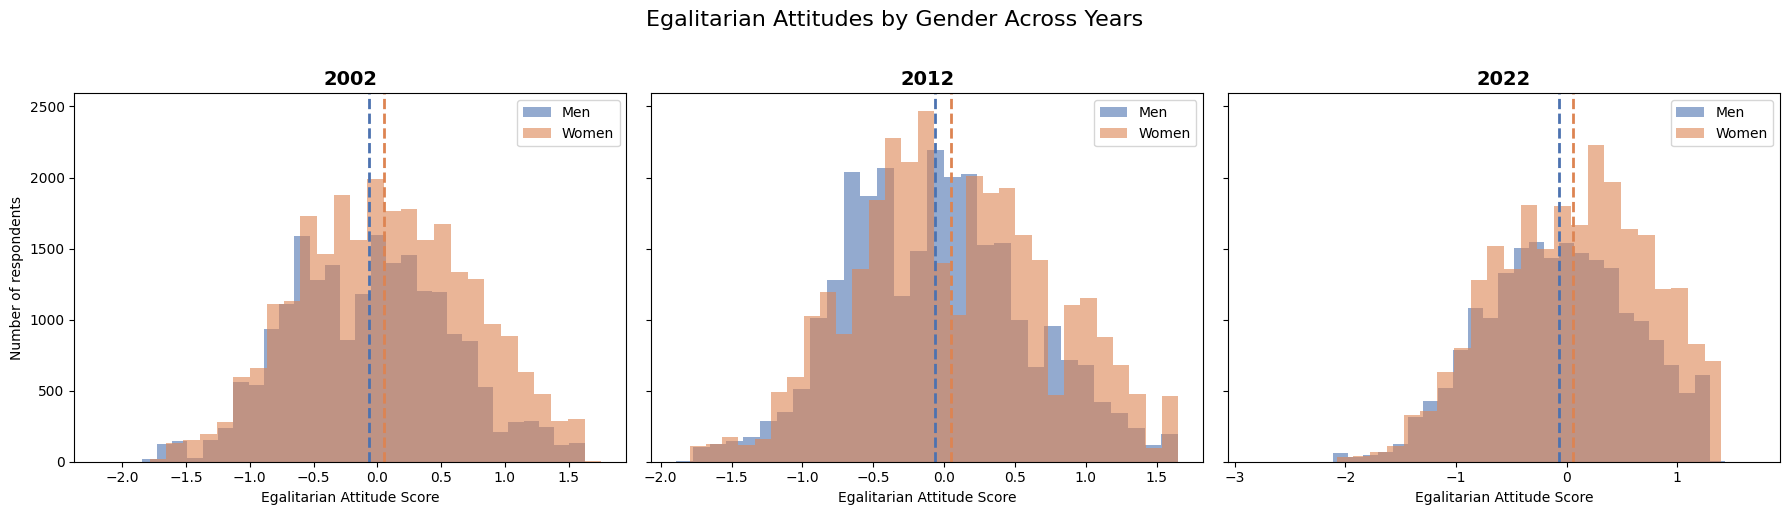

In [45]:
men_color = '#4C72B0'
women_color = '#DD8452'

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

years = [2002, 2012, 2022]
dfs = [df_2002_only_egal, df_2012_only_egal, df_2022_only_egal]

for ax, year, df in zip(axes, years, dfs):
    men_mean = df.loc[df['sex'] == 'Male', 'eg_score'].mean()
    women_mean = df.loc[df['sex'] == 'Female', 'eg_score'].mean()
    
    ax.hist(
        df.loc[df['sex'] == 'Male', 'eg_score'].dropna(),
        bins=30, alpha=0.6, label='Men', color=men_color
    )
    
    ax.hist(
        df.loc[df['sex'] == 'Female', 'eg_score'].dropna(),
        bins=30, alpha=0.6, label='Women', color=women_color
    )
    
    ax.axvline(men_mean, linestyle='--', linewidth=2, color=men_color)
    ax.axvline(women_mean, linestyle='--', linewidth=2, color=women_color)
    
    ax.set_xlabel('Egalitarian Attitude Score')
    ax.set_title(f'{year}', fontsize=14, fontweight='bold')
    ax.legend()

axes[0].set_ylabel('Number of respondents')
fig.suptitle('Egalitarian Attitudes by Gender Across Years', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

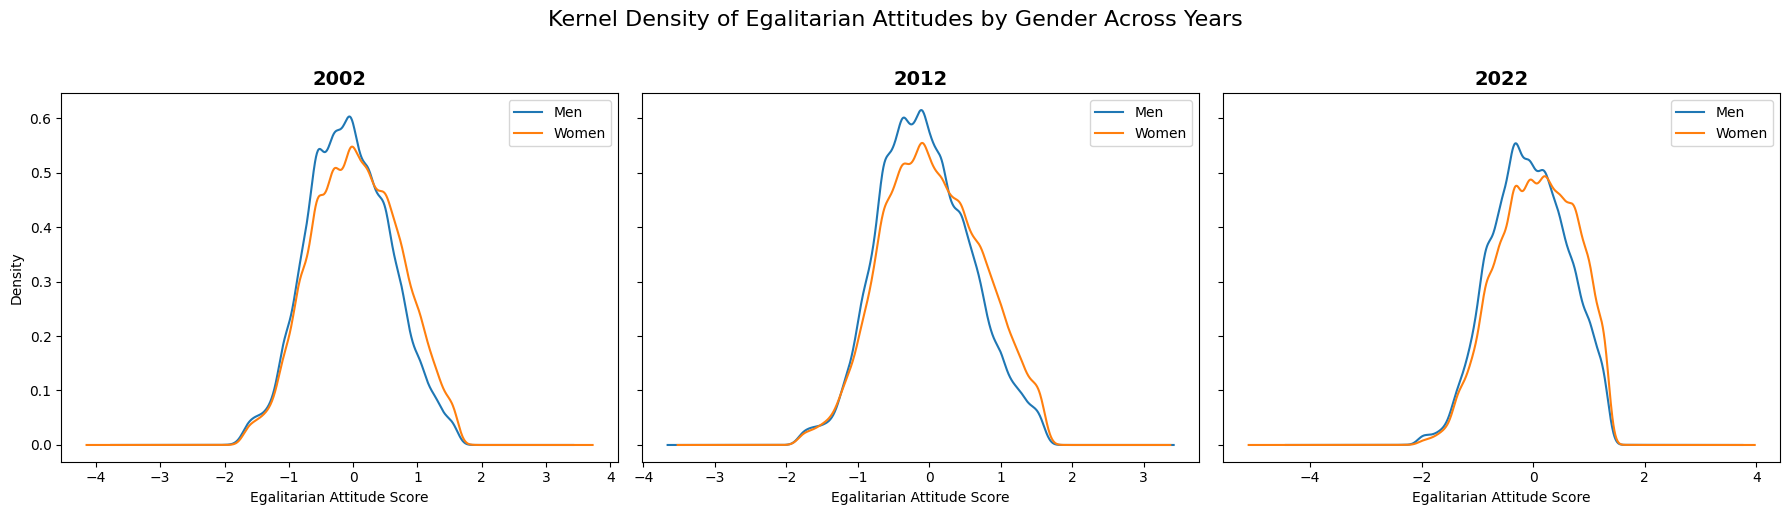

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

years = [2002, 2012, 2022]
dfs = [df_2002_only_egal, df_2012_only_egal, df_2022_only_egal]

for ax, year, df in zip(axes, years, dfs):
    df.loc[df['sex'] == 'Male', 'eg_score'].plot(
        kind='kde', label='Men', ax=ax
    )
    
    df.loc[df['sex'] == 'Female', 'eg_score'].plot(
        kind='kde', label='Women', ax=ax
    )
    
    ax.set_xlabel('Egalitarian Attitude Score')
    ax.set_title(f'{year}', fontsize=14, fontweight='bold')
    ax.legend()

axes[0].set_ylabel('Density')
fig.suptitle('Kernel Density of Egalitarian Attitudes by Gender Across Years', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [47]:
%%capture
df_2002_only_egal["hh_wrk_hrs"] = df_2002["v36"]
df_2012_only_egal["hh_wrk_hrs"] = df_2012["V37"]
df_2022_only_egal["hh_wrk_hrs"] = df_2022["v34"]

In [48]:
%%capture
df_2002_only_egal["hh_wrk_hrs"] = df_2002_only_egal["hh_wrk_hrs"].astype(float)
df_2012_only_egal["hh_wrk_hrs"] = df_2012_only_egal["hh_wrk_hrs"].astype(float)
df_2022_only_egal["hh_wrk_hrs"] = df_2022_only_egal["hh_wrk_hrs"].astype(float)

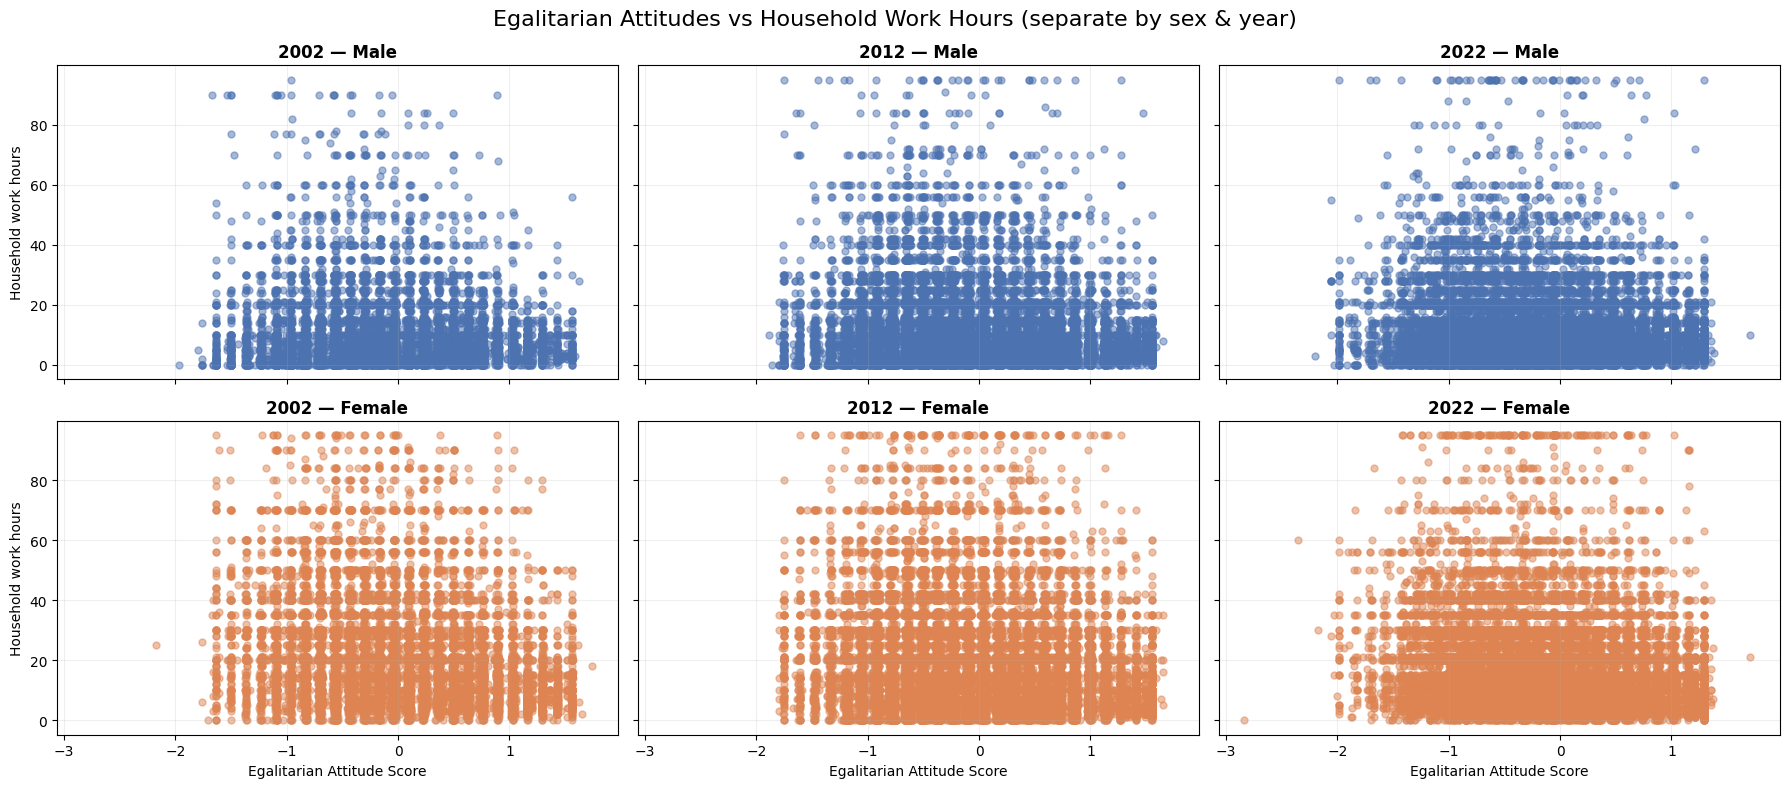

In [49]:
men_color = '#4C72B0'
women_color = '#DD8452'

fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)

years = [2002, 2012, 2022]
dfs = [df_2002_only_egal, df_2012_only_egal, df_2022_only_egal]
sex_rows = ["Male", "Female"]
colors = {"Male": men_color, "Female": women_color}

for col, (year, df) in enumerate(zip(years, dfs)):
    sub = df.dropna(subset=["eg_score", "hh_wrk_hrs", "sex"])
    for row, sex in enumerate(sex_rows):
        ax = axes[row, col]
        ax.scatter(
            sub.loc[sub["sex"] == sex, "eg_score"],
            sub.loc[sub["sex"] == sex, "hh_wrk_hrs"],
            color=colors[sex], alpha=0.5, s=25, label=sex
        )
        if row == 1:
            ax.set_xlabel("Egalitarian Attitude Score")
        if col == 0:
            ax.set_ylabel("Household work hours")
        ax.set_title(f"{year} — {sex}", fontsize=12, fontweight="bold")
        ax.grid(alpha=0.2)

fig.suptitle("Egalitarian Attitudes vs Household Work Hours (separate by sex & year)", fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

## Correlation between eg_score and household work hours by sex and year

In [50]:
years = [2002, 2012, 2022]
dfs = [df_2002_only_egal, df_2012_only_egal, df_2022_only_egal]
sexes = ["Male", "Female"]

rows = []
for year, df in zip(years, dfs):
    sub = df.dropna(subset=["eg_score", "hh_wrk_hrs", "sex"])
    for sex in sexes:
        d = sub[sub["sex"] == sex]
        r = d["eg_score"].corr(d["hh_wrk_hrs"])
        rows.append({"year": year, "sex": sex, "correlation": r})

corr_df = pd.DataFrame(rows)
corr_df

,year,sex,correlation
0,2002,Male,-0.072033
1,2002,Female,-0.266064
2,2012,Male,-0.091544
3,2012,Female,-0.211345
4,2022,Male,-0.136189
5,2022,Female,-0.237095


## Conclusion
For Females, 
the correlation is negative, which means as women become more egalitarian, they reduce household work hours, which can be because they resist traditional gender norms. 

For Men,
The correlation coefficient remains close to zero, indicationg no effect of becoming more or less egalitarian

In [51]:
%%capture
df_2002_only_egal["wrk_hrs"] = df_2002["v240"]
df_2012_only_egal["wrk_hrs"] = df_2012["WRKHRS"]
df_2022_only_egal["wrk_hrs"] = df_2022["WRKHRS"]

## Three way correlation between eg_score, hh work hours and paid work hours
 To check whether increase in eg score and reduction in hh work hours is just because of becoming more educated and increasing paid work

In [52]:
df_2022_only_egal[df_2022_only_egal["sex"] == "Male"][["eg_score", "hh_wrk_hrs", "wrk_hrs"]].corr()

,eg_score,hh_wrk_hrs,wrk_hrs
eg_score,1.000000,-0.136189,-0.065914
hh_wrk_hrs,-0.136189,1.000000,0.068777
wrk_hrs,-0.065914,0.068777,1.000000


In [53]:
df_2022_only_egal[df_2022_only_egal["sex"] == "Female"][["eg_score", "hh_wrk_hrs", "wrk_hrs"]].corr()

,eg_score,hh_wrk_hrs,wrk_hrs
eg_score,1.000000,-0.237095,-0.024546
hh_wrk_hrs,-0.237095,1.000000,0.053791
wrk_hrs,-0.024546,0.053791,1.000000


In [54]:
%%capture
# Set the country column per source df
country_cols = {
    2002: 'C_ALPHAN',        # replace if different
    2012: 'V4',        # e.g., "DE-Germany"
    2022: 'c_alphan',   # replace if different (or 'CNTRY')
}

# Copy country codes into the egal-only frames
df_2002_only_egal['country'] = df_2002[country_cols[2002]]

df_2012_only_egal['country'] = (
    df_2012[country_cols[2012]].str.split('-', n=1).str[0].str.strip()  # ISO2 from "DE-Germany"
)

df_2022_only_egal['country'] = df_2022[country_cols[2022]]

## Plotting mean eg_scores by country

In [55]:
import pycountry

def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except Exception:
        return None

def plot_mean_eg_map(df, title):
    tmp = df.copy()
    # handle values like "DE-Germany" or bare ISO2
    tmp["iso2"] = tmp["country"].astype(str).str.split("-", n=1).str[0].str.strip()
    tmp["iso3"] = tmp["iso2"].apply(iso2_to_iso3)
    tmp = tmp.dropna(subset=["iso3"])
    country_mean = tmp.groupby("iso3", as_index=False)["eg_score"].mean()

    fig = px.choropleth(
        country_mean,
        locations="iso3",
        locationmode="ISO-3",
        color="eg_score",
        color_continuous_scale="Viridis",
        labels={"eg_score": "Mean egalitarian score"},
        title=title,
    )
    fig.update_layout(geo=dict(showframe=False, showcoastlines=True))
    pio.renderers.default = "browser"
    fig.show()

plot_mean_eg_map(df_2002_only_egal, "Mean egalitarian score (2002)")
plot_mean_eg_map(df_2012_only_egal, "Mean egalitarian score (2012)")
plot_mean_eg_map(df_2022_only_egal, "Mean egalitarian score (2022)")

In [56]:
# Clean age column in 2002 and make numeric
invalid_age = {
    "Don't know",
    "No answer",
    "Refused",
    "Not available",
}

def to_numeric_age_2002(val):
    if val is None:
        return None
    s = str(val)
    if s in invalid_age:
        return None
    # keep leading digits (handles categories like "89 or more")
    import re
    m = re.search(r"\d+", s)
    return int(m.group()) if m else None

df_2002["age_num"] = df_2002["v201"].apply(to_numeric_age_2002).astype("float")
df_2002[["v201", "age_num"]].head()

,v201,age_num
0,46.0,46.0
1,40.0,40.0
2,68.0,68.0
3,69.0,69.0
4,44.0,44.0


In [57]:
invalid_age_2012 = {
    "Don't know",
    "No answer",
    "Refused",
    "Not available",
}

def to_numeric_age_2012(val):
    if val is None:
        return None
    s = str(val)
    if s in invalid_age_2012:
        return None
    import re
    m = re.search(r"\d+", s)  # grabs leading digits, e.g. "89 or more"
    return int(m.group()) if m else None

df_2012["age_num"] = df_2012["AGE"].apply(to_numeric_age_2012).astype("float")
df_2012[["AGE", "age_num"]].head()

,AGE,age_num
0,35,35.0
1,24,24.0
2,18 years,18.0
3,61,61.0
4,55,55.0


In [58]:
invalid_age_2022 = {
    "Don't know",
    "No answer",
    "Refused",
    "Not available",
}

def to_numeric_age_2022(val):
    if val is None:
        return None
    s = str(val)
    if s in invalid_age_2022:
        return None
    import re
    m = re.search(r"\d+", s)  # handles values like "89 or more"
    return int(m.group()) if m else None

df_2022["age_num"] = df_2022["AGE"].apply(to_numeric_age_2022).astype(float)
df_2022[["AGE", "age_num"]].head()

,AGE,age_num
0,46,46.0
1,59,59.0
2,28,28.0
3,60,60.0
4,43,43.0


In [59]:
df_2002_only_egal["age"] = df_2002["age_num"]
df_2012_only_egal["age"] = df_2012["age_num"]
df_2022_only_egal["age"] = df_2022["age_num"]

## To-do (Put this in Validation section)

## Checking Correlation between age and eg_score 
Obvious result- Eg_score decreases with age

In [60]:
print(df_2002_only_egal[["age", "eg_score"]].corr())
print(df_2012_only_egal[["age", "eg_score"]].corr())
print(df_2022_only_egal[["age", "eg_score"]].corr())

               age  eg_score
age       1.000000 -0.229377
eg_score -0.229377  1.000000
              age  eg_score
age       1.00000  -0.11256
eg_score -0.11256   1.00000
               age  eg_score
age       1.000000 -0.051858
eg_score -0.051858  1.000000


In [61]:
df_2022_only_egal[df_2022_only_egal["age"] == 15]
# df_20

,v1_egal,v2_egal,v3_egal,v4_egal,v5_egal,v6_egal,v1_egal_z,v2_egal_z,v3_egal_z,v4_egal_z,v5_egal_z,v6_egal_z,eg_score,sex,hh_wrk_hrs,wrk_hrs,country,age
12035,2.0,3.0,2.0,2.0,2.0,4.0,-1.886553,-0.245997,-1.100712,-0.965665,-0.787051,0.297613,-0.781394,Female,1.0,NaN,FI,15.0
12130,5.0,5.0,4.0,3.0,2.0,5.0,0.957082,1.374234,0.488632,-0.183383,-0.787051,1.044341,0.482309,Female,2.0,NaN,FI,15.0
12179,5.0,5.0,5.0,4.0,3.0,5.0,0.957082,1.374234,1.283303,0.598900,0.042978,1.044341,0.883473,Female,3.0,3.0,FI,15.0
12425,5.0,5.0,5.0,2.0,1.0,5.0,0.957082,1.374234,1.283303,-0.965665,-1.617080,1.044341,0.346036,Female,2.0,NaN,FI,15.0
12569,2.0,2.0,NaN,NaN,3.0,5.0,-1.886553,-1.056113,NaN,NaN,0.042978,1.044341,-0.463837,Male,4.0,NaN,FI,15.0
12723,4.0,5.0,4.0,3.0,2.0,5.0,0.009203,1.374234,0.488632,-0.183383,-0.787051,1.044341,0.324329,Female,2.0,NaN,FI,15.0


In [62]:
# Bin age into categories for all three datasets
df_2002_only_egal["age_bin"] = pd.cut(
    df_2002_only_egal["age"],
    bins=[0, 17, 25, 35, 45, 55, 65, 75, 100],
    labels=["<18","18-25", "26-35", "36-45", "46-55", "56-65", "66-75", "75+"]
)

df_2012_only_egal["age_bin"] = pd.cut(
    df_2012_only_egal["age"],
    bins=[0, 17, 25, 35, 45, 55, 65, 75, 100],
    labels=["<18", "18-25", "26-35", "36-45", "46-55", "56-65", "66-75", "75+"]
)

df_2022_only_egal["age_bin"] = pd.cut(
    df_2022_only_egal["age"],
    bins=[0, 17, 25, 35, 45, 55, 65, 75, 100],
    labels=["<18", "18-25", "26-35", "36-45", "46-55", "56-65", "66-75", "75+"]
)


In [63]:
# Compute mean eg_score by age_bin for each year
eg_2002 = df_2002_only_egal[df_2002_only_egal["sex"] == "Male"].groupby("age_bin")["eg_score"].mean()
eg_2012 = df_2012_only_egal[df_2012_only_egal["sex"] == "Male"].groupby("age_bin")["eg_score"].mean()
eg_2022 = df_2022_only_egal[df_2022_only_egal["sex"] == "Male"].groupby("age_bin")["eg_score"].mean()

# Combine into one DataFrame
df_eg_score_by_age_male = pd.DataFrame({
    "2002": eg_2002,
    "2012": eg_2012,
    "2022": eg_2022
})

df_eg_score_by_age_male

,2002,2012,2022
age_bin,,,
<18,0.191580,0.081410,-0.028044
18-25,0.049112,0.005464,-0.090740
26-35,0.068931,0.011082,-0.064198
36-45,0.015726,-0.032321,-0.070628
46-55,-0.043419,-0.030885,-0.019333
56-65,-0.169528,-0.076730,-0.043741
66-75,-0.335320,-0.170276,-0.083350
75+,-0.437955,-0.310445,-0.214129


In [64]:
# Compute mean eg_score by age_bin for each year
eg_2002 = df_2002_only_egal[df_2002_only_egal["sex"] == "Female"].groupby("age_bin")["eg_score"].mean()
eg_2012 = df_2012_only_egal[df_2012_only_egal["sex"] == "Female"].groupby("age_bin")["eg_score"].mean()
eg_2022 = df_2022_only_egal[df_2022_only_egal["sex"] == "Female"].groupby("age_bin")["eg_score"].mean()

# Combine into one DataFrame
df_eg_score_by_age_female = pd.DataFrame({
    "2002": eg_2002,
    "2012": eg_2012,
    "2022": eg_2022
})

df_eg_score_by_age_female

,2002,2012,2022
age_bin,,,
<18,0.364213,0.130785,0.287616
18-25,0.214532,0.130578,0.163574
26-35,0.167858,0.097948,0.068928
36-45,0.143536,0.087485,0.051561
46-55,0.064168,0.097352,0.079630
56-65,-0.083406,0.038199,0.081518
66-75,-0.243718,-0.052580,0.036733
75+,-0.358017,-0.240940,-0.124503


In [65]:
dfs = [df_2002_only_egal, df_2012_only_egal, df_2022_only_egal]

for df in dfs:
    for col in df.columns:
        if col.endswith("_egal") or col.endswith("_z"):
            df[col] = df[col].astype(float)

In [66]:
eg_score_by_year = pd.DataFrame({
    "2002": [df_2002_only_egal["eg_score"].mean()],
    "2012": [df_2012_only_egal["eg_score"].mean()],
    "2022": [df_2022_only_egal["eg_score"].mean()]
})
eg_score_by_year

,2002,2012,2022
0,0.000133,-0.000409,0.001901


## To do- Put below the section of three way correlation

## Making a regression model to check the association between eg_scores and wrk_hrs

In [67]:
import statsmodels.formula.api as smf

# Prepare data
data = df_2002_only_egal[["wrk_hrs", "eg_score", "sex"]].copy()

# Convert wrk_hrs to numeric (handles strings, invalid values → NaN)
data["wrk_hrs"] = pd.to_numeric(data["wrk_hrs"], errors="coerce")

# Drop rows with any missing values
data = data.dropna()

# Convert sex to numeric (0 = Female, 1 = Male)
data["sex_numeric"] = (data["sex"] == "Male").astype(int)

model = smf.ols(
    "wrk_hrs ~ eg_score * sex_numeric",
    data=data
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                wrk_hrs   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     670.2
Date:                Fri, 09 Jan 2026   Prob (F-statistic):               0.00
Time:                        12:22:43   Log-Likelihood:            -1.1109e+05
No. Observations:               26891   AIC:                         2.222e+05
Df Residuals:                   26887   BIC:                         2.222e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               37.9234 

In [68]:
import statsmodels.formula.api as smf

# Prepare data
data = df_2002_only_egal[["hh_wrk_hrs", "eg_score", "sex"]].copy()

# Convert wrk_hrs to numeric (handles strings, invalid values → NaN)
data["hh_wrk_hrs"] = pd.to_numeric(data["hh_wrk_hrs"], errors="coerce")

# Drop rows with any missing values
data = data.dropna()

# Convert sex to numeric (0 = Female, 1 = Male)
data["sex_numeric"] = (data["sex"] == "Male").astype(int)

model = smf.ols(
    "hh_wrk_hrs ~ eg_score * sex_numeric",
    data=data
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             hh_wrk_hrs   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     2594.
Date:                Fri, 09 Jan 2026   Prob (F-statistic):               0.00
Time:                        12:22:43   Log-Likelihood:            -1.2006e+05
No. Observations:               29922   AIC:                         2.401e+05
Df Residuals:                   29918   BIC:                         2.402e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               21.5097 

In [69]:
import statsmodels.formula.api as smf

# Prepare data (include hh_wrk_hrs as predictor)
data = df_2002_only_egal[["wrk_hrs", "hh_wrk_hrs", "eg_score", "sex"]].copy()

# Ensure numeric
data["wrk_hrs"] = pd.to_numeric(data["wrk_hrs"], errors="coerce")
data["hh_wrk_hrs"] = pd.to_numeric(data["hh_wrk_hrs"], errors="coerce")

# Drop rows with missing
data = data.dropna(subset=["wrk_hrs", "hh_wrk_hrs", "eg_score", "sex"])

# Encode sex
data["sex_numeric"] = (data["sex"] == "Male").astype(int)

# Include hh_wrk_hrs as independent variable
model = smf.ols(
    "wrk_hrs ~ eg_score * sex_numeric + hh_wrk_hrs",
    data=data
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                wrk_hrs   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     469.3
Date:                Fri, 09 Jan 2026   Prob (F-statistic):               0.00
Time:                        12:22:43   Log-Likelihood:                -77360.
No. Observations:               18901   AIC:                         1.547e+05
Df Residuals:                   18896   BIC:                         1.548e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               37.5938 

In [70]:
import statsmodels.formula.api as smf

# Prepare data (include hh_wrk_hrs as predictor)
data = df_2002_only_egal[["wrk_hrs", "hh_wrk_hrs", "eg_score", "sex"]].copy()

# Ensure numeric
data["wrk_hrs"] = pd.to_numeric(data["wrk_hrs"], errors="coerce")
data["hh_wrk_hrs"] = pd.to_numeric(data["hh_wrk_hrs"], errors="coerce")

# Drop rows with missing
data = data.dropna(subset=["wrk_hrs", "hh_wrk_hrs", "eg_score", "sex"])

# Encode sex
data["sex_numeric"] = (data["sex"] == "Male").astype(int)

# Include hh_wrk_hrs as independent variable
model = smf.ols(
    "hh_wrk_hrs ~ eg_score * sex_numeric + wrk_hrs",
    data=data
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             hh_wrk_hrs   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     1001.
Date:                Fri, 09 Jan 2026   Prob (F-statistic):               0.00
Time:                        12:22:43   Log-Likelihood:                -71658.
No. Observations:               18901   AIC:                         1.433e+05
Df Residuals:                   18896   BIC:                         1.434e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               18.6237 

In [71]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# -----------------------------
# Settings
# -----------------------------
years = [2002, 2012, 2022]
dfs = {
    2002: df_2002_only_egal,
    2012: df_2012_only_egal,
    2022: df_2022_only_egal
}

# Models you want to run (same spec each year)
MODEL_SPECS = {
    "M1_paid_on_egal": "wrk_hrs ~ eg_score * sex_numeric",
    "M2_house_on_egal": "hh_wrk_hrs ~ eg_score * sex_numeric",
    "M3_paid_on_egal_plus_house": "wrk_hrs ~ eg_score * sex_numeric + hh_wrk_hrs",
    "M4_house_on_egal_plus_paid": "hh_wrk_hrs ~ eg_score * sex_numeric + wrk_hrs",
}

# Minimal output: only what you need to interpret + compare
KEEP_TERMS = ["eg_score", "sex_numeric", "eg_score:sex_numeric", "hh_wrk_hrs", "wrk_hrs"]

# -----------------------------
# Helper to run & collect output
# -----------------------------
def run_year_models(df, year):
    df = df.copy()

    # Ensure numeric (coerce invalid to NaN)
    for c in ["wrk_hrs", "hh_wrk_hrs", "eg_score"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Encode sex (0 = Female, 1 = Male)
    df = df.dropna(subset=["sex"])
    df["sex_numeric"] = (df["sex"] == "Male").astype(int)

    out_rows = []

    for model_name, formula in MODEL_SPECS.items():
        # Identify required columns for this formula
        required = ["eg_score", "sex_numeric"]
        if "wrk_hrs" in formula:
            required.append("wrk_hrs")
        if "hh_wrk_hrs" in formula:
            required.append("hh_wrk_hrs")

        data = df.dropna(subset=required).copy()

        # Fit
        res = smf.ols(formula, data=data).fit()

        # Collect only what you need
        params = res.params
        bse = res.bse
        pvals = res.pvalues

        # Compute slopes for women (sex=0) and men (sex=1)
        # Women slope on eg_score = beta_eg
        # Men slope on eg_score = beta_eg + beta_interaction
        beta_eg = params.get("eg_score", np.nan)
        beta_int = params.get("eg_score:sex_numeric", 0.0)  # if term absent, treat as 0
        slope_women = beta_eg
        slope_men = beta_eg + beta_int

        row = {
            "year": year,
            "model": model_name,
            "n": int(res.nobs),
            "r2": float(res.rsquared),
            "beta_eg_score": float(beta_eg) if pd.notnull(beta_eg) else np.nan,
            "beta_interaction": float(params.get("eg_score:sex_numeric", np.nan)),
            "slope_eg_women": float(slope_women) if pd.notnull(slope_women) else np.nan,
            "slope_eg_men": float(slope_men) if pd.notnull(slope_men) else np.nan,
            "p_eg_score": float(pvals.get("eg_score", np.nan)),
            "p_interaction": float(pvals.get("eg_score:sex_numeric", np.nan)),
        }

        # Add only the extra covariate if present in that model
        if "hh_wrk_hrs" in formula:
            row["beta_hh_wrk_hrs"] = float(params.get("hh_wrk_hrs", np.nan))
            row["p_hh_wrk_hrs"] = float(pvals.get("hh_wrk_hrs", np.nan))
        else:
            row["beta_hh_wrk_hrs"] = np.nan
            row["p_hh_wrk_hrs"] = np.nan

        if "wrk_hrs" in formula and model_name == "M4_house_on_egal_plus_paid":
            row["beta_wrk_hrs"] = float(params.get("wrk_hrs", np.nan))
            row["p_wrk_hrs"] = float(pvals.get("wrk_hrs", np.nan))
        else:
            row["beta_wrk_hrs"] = np.nan
            row["p_wrk_hrs"] = np.nan

        out_rows.append(row)

    return pd.DataFrame(out_rows)

# -----------------------------
# Run all years & show once
# -----------------------------
all_results = []
for y in years:
    all_results.append(run_year_models(dfs[y], y))

results_df = pd.concat(all_results, ignore_index=True)

# Optional: nicer ordering
results_df = results_df[
    [
        "year", "model", "n", "r2",
        "beta_eg_score", "beta_interaction",
        "slope_eg_women", "slope_eg_men",
        "beta_hh_wrk_hrs", "beta_wrk_hrs",
        "p_eg_score", "p_interaction", "p_hh_wrk_hrs", "p_wrk_hrs"
    ]
].sort_values(["model", "year"]).reset_index(drop=True)

# Display
results_df

,year,model,n,r2,beta_eg_score,beta_interaction,slope_eg_women,slope_eg_men,beta_hh_wrk_hrs,beta_wrk_hrs,p_eg_score,p_interaction,p_hh_wrk_hrs,p_wrk_hrs
0,2002,M1_paid_on_egal,26891,0.069577,-1.736020,-0.597182,-1.736020,-2.333202,NaN,NaN,1.996684e-18,3.598082e-02,NaN,NaN
1,2012,M1_paid_on_egal,30841,0.057608,-1.548437,-0.177010,-1.548437,-1.725448,NaN,NaN,2.979638e-19,4.733676e-01,NaN,NaN
2,2022,M1_paid_on_egal,24739,0.040758,-0.485085,-0.830423,-0.485085,-1.315508,NaN,NaN,6.067349e-03,9.966281e-04,NaN,NaN
3,2002,M2_house_on_egal,18901,0.174398,-4.793351,4.039248,-4.793351,-0.754103,NaN,NaN,1.122056e-171,3.000470e-62,NaN,NaN
4,2012,M2_house_on_egal,30161,0.097575,-3.833653,2.533118,-3.833653,-1.300535,NaN,NaN,3.248854e-191,1.156453e-42,NaN,NaN
5,2022,M2_house_on_egal,24015,0.074972,-4.382248,2.134619,-4.382248,-2.247629,NaN,NaN,5.813217e-198,4.846590e-25,NaN,NaN
6,2002,M3_paid_on_egal_plus_house,18901,0.090367,-1.191089,-0.647107,-1.191089,-1.838197,-0.032827,NaN,3.769816e-07,4.929138e-02,8.442128e-04,NaN
7,2012,M3_paid_on_egal_plus_house,30161,0.057332,-1.542842,-0.173955,-1.542842,-1.716797,0.010312,NaN,2.718961e-18,4.869405e-01,1.848000e-01,NaN
8,2022,M3_paid_on_egal_plus_house,24015,0.042562,-0.161166,-1.015556,-0.161166,-1.176721,0.067078,NaN,3.789177e-01,7.777051e-05,6.478361e-17,NaN
9,2002,M4_house_on_egal_plus_paid,18901,0.174885,-4.811913,4.025247,-4.811913,-0.786666,NaN,-0.017956,7.087465e-173,7.555456e-62,NaN,8.442128e-04


In [72]:
df_2002_only_egal["high_egal"] = df_2002_only_egal["eg_score"] > df_2002_only_egal["eg_score"].median()
df_2002_only_egal["low_housework"] = df_2002_only_egal["hh_wrk_hrs"] < df_2002_only_egal["hh_wrk_hrs"].median()
df_2002_only_egal[df_2002_only_egal["high_egal"] & df_2002_only_egal["low_housework"] & (df_2002_only_egal["sex"] == "Male")]

,v4_egal,v5_egal,v6_egal,v7_egal,v8_egal,v11_egal,v4_egal_z,v5_egal_z,v6_egal_z,v7_egal_z,...,v11_egal_z,eg_score,sex,hh_wrk_hrs,wrk_hrs,country,age,age_bin,high_egal,low_housework
1,5.0,5.0,5.0,5.0,1.0,5.0,1.105198,1.788120,1.680397,1.741713,...,1.291647,1.019445,Male,5.0,NaN,AU,40.0,36-45,True,True
11,5.0,5.0,3.0,3.0,3.0,4.0,1.105198,1.788120,0.108813,0.125346,...,0.529385,0.632932,Male,3.0,40.0,AU,37.0,36-45,True,True
25,5.0,3.0,4.0,3.0,1.0,5.0,1.105198,0.186683,0.894605,0.125346,...,1.291647,0.352179,Male,6.0,30.0,AU,62.0,56-65,True,True
34,3.0,3.0,2.0,4.0,3.0,4.0,-0.536287,0.186683,-0.676980,0.933529,...,0.529385,0.096176,Male,7.0,46.0,AU,32.0,26-35,True,True
72,4.0,3.0,4.0,3.0,2.0,4.0,0.284456,0.186683,0.894605,0.125346,...,0.529385,0.224273,Male,6.0,NaN,AU,42.0,36-45,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46597,4.0,4.0,4.0,2.0,2.0,2.0,0.284456,0.987401,0.894605,-0.682838,...,-0.995140,-0.031059,Male,7.0,NaN,TW,31.0,26-35,True,True
46598,4.0,2.0,4.0,NaN,2.0,4.0,0.284456,-0.614036,0.894605,NaN,...,0.529385,0.083914,Male,5.0,40.0,TW,35.0,26-35,True,True
46599,5.0,3.0,5.0,2.0,2.0,NaN,1.105198,0.186683,1.680397,-0.682838,...,NaN,0.322920,Male,5.0,88.0,TW,28.0,26-35,True,True
46600,4.0,3.0,NaN,2.0,3.0,4.0,0.284456,0.186683,NaN,-0.682838,...,0.529385,0.091683,Male,0.0,48.0,TW,59.0,56-65,True,True


In [73]:
df_2012_only_egal["high_egal"] = df_2012_only_egal["eg_score"] > df_2012_only_egal["eg_score"].median()
df_2012_only_egal["low_housework"] = df_2012_only_egal["hh_wrk_hrs"] < df_2012_only_egal["hh_wrk_hrs"].median()

In [74]:
df_2022_only_egal["high_egal"] = df_2022_only_egal["eg_score"] > df_2022_only_egal["eg_score"].median()
df_2022_only_egal["low_housework"] = df_2022_only_egal["hh_wrk_hrs"] < df_2022_only_egal["hh_wrk_hrs"].median()

In [75]:
df_2002_only_egal["highest_education"] = df_2002["v205"]
df_2012_only_egal["highest_education"] = df_2012["DEGREE"]
df_2022_only_egal["highest_education"] = df_2022["EDULEVEL"]

In [76]:
import numpy as np
import pandas as pd
import re

def clean_education(df, year, educ_col, new_col="educ_4"):
    """
    Creates a harmonized education variable across waves.
    Keeps original column; adds df[new_col] with 4 categories.
    """
    d = df.copy()
    s = d[educ_col].astype(str).str.strip()

    # Treat missing-ish / no-answer categories as NaN
    missing_patterns = [
        r"^-9", r"^-8", r"no answer", r"don't know", r"cant choose", r"can't choose",
        r"not classifiable", r"not codable"
    ]
    miss_re = re.compile("|".join(missing_patterns), flags=re.IGNORECASE)
    s = s.mask(s.str.contains(miss_re), np.nan)

    # --- 2002: "University degree completed", "Higher secondary completed", etc. ---
    if year == 2002:
        def map_2002(x):
            if pd.isna(x): return np.nan
            x = x.lower()
            if "no formal" in x or "lowest formal" in x:
                return 0
            if "higher secondary completed" in x:
                return 1
            if "above lowest" in x or "above higher sec" in x:
                return 2
            if "university degree completed" in x:
                return 3
            return np.nan

        d[new_col] = s.map(map_2002)

    # --- 2012: Primary / lower secondary / upper secondary / tertiary levels ---
    elif year == 2012:
        def map_2012(x):
            if pd.isna(x): return np.nan
            x = x.lower()
            if "no formal education" in x or "primary" in x:
                return 0
            if "lower secondary" in x or "upper secondary" in x:
                return 1
            if "post secondary, non-tertiary" in x or "lower level tertiary" in x:
                # includes short-cycle / technical tertiary
                return 2
            if "upper level tertiary" in x or "master" in x or "dr" in x or "phd" in x:
                return 3
            return np.nan

        d[new_col] = s.map(map_2012)

    # --- 2022: numeric-coded labels 0..8 embedded in strings ---
    elif year == 2022:
        # Extract leading integer if present (e.g., "6. Lower level tertiary, BA")
        code = pd.to_numeric(s.str.extract(r"^\s*([0-9]+)")[0], errors="coerce")

        # Map numeric codes to 4 bins
        # 0-1: none/primary
        # 2-3: secondary
        # 4-5: post-secondary non-tertiary / short-cycle tertiary
        # 6-8: BA+
        d[new_col] = np.select(
            [
                code.isna(),
                code.isin([0, 1]),
                code.isin([2, 3]),
                code.isin([4, 5]),
                code.isin([6, 7, 8]),
            ],
            [np.nan, 0, 1, 2, 3],
            default=np.nan
        )

    else:
        raise ValueError("year must be one of {2002, 2012, 2022}")

    # Optional: add readable labels too
    labels = {
        0: "No/Primary",
        1: "Secondary",
        2: "Post-sec / Short tertiary",
        3: "University+",
    }
    d[new_col + "_label"] = d[new_col].map(labels)

    return d

In [77]:
df_2002_only_egal = clean_education(df_2002_only_egal, 2002, educ_col="highest_education", new_col="educ_4")
df_2012_only_egal = clean_education(df_2012_only_egal, 2012, educ_col="highest_education", new_col="educ_4")
df_2022_only_egal = clean_education(df_2022_only_egal, 2022, educ_col="highest_education", new_col="educ_4")


## Change in eg_scores by education

In [78]:
order = ["No/Primary", "Secondary", "Post-sec / Short tertiary", "University+"]

idx = (
    pd.Index(df_2002_only_egal["educ_4_label"].dropna().unique())
    .union(df_2012_only_egal["educ_4_label"].dropna().unique())
    .union(df_2022_only_egal["educ_4_label"].dropna().unique())
)

means_by_educ = pd.DataFrame(index=idx, columns=["2002", "2012", "2022"])
means_by_educ["2002"] = df_2002_only_egal.groupby("educ_4_label")["eg_score"].mean()
means_by_educ["2012"] = df_2012_only_egal.groupby("educ_4_label")["eg_score"].mean()
means_by_educ["2022"] = df_2022_only_egal.groupby("educ_4_label")["eg_score"].mean()

means_by_educ = means_by_educ.reindex(order)
means_by_educ

,2002,2012,2022
No/Primary,-0.296747,-0.349214,-0.472438
Secondary,0.072491,-0.037175,-0.109922
Post-sec / Short tertiary,0.027118,0.224697,0.063214
University+,0.320431,0.452181,0.260254


In [79]:
df_2002_only_egal[(df_2002_only_egal["educ_4"] >= 2) & 
                  (~df_2002_only_egal["high_egal"]) & 
                  (df_2002_only_egal["sex"] == "Male")]["hh_wrk_hrs"].mean()

np.float64(9.62396102034967)

In [80]:
df_2002_only_egal[(df_2002_only_egal["educ_4"] < 2) 
                  & (~df_2002_only_egal["high_egal"]) & 
                  (df_2002_only_egal["sex"] == "Male")]["hh_wrk_hrs"].mean()

np.float64(9.518673282841473)

In [81]:
df_2002_only_egal[(df_2002_only_egal["educ_4"] >= 2) & 
                  (df_2002_only_egal["high_egal"]) & 
                  (df_2002_only_egal["sex"] == "Female")]["hh_wrk_hrs"].mean()

np.float64(16.65995700605824)

In [82]:
df_2002_only_egal[(df_2002_only_egal["educ_4"] < 2) 
                  & (df_2002_only_egal["high_egal"]) & 
                  (df_2002_only_egal["sex"] == "Female")]["hh_wrk_hrs"].mean()

np.float64(19.618238459359954)

In [83]:
%%capture
def hh_confusion(df):
    return (
        df.pivot_table(
            index="sex",
            columns="high_egal",
            values="hh_wrk_hrs",
            aggfunc="mean"
        )
        .rename(columns={True: "High egal", False: "Low egal"})
        .loc[["Male", "Female"]]
    )

cm_2002 = hh_confusion(df_2002_only_egal)
cm_2012 = hh_confusion(df_2012_only_egal)
cm_2022 = hh_confusion(df_2022_only_egal)

cm_2002, cm_2012, cm_2022

In [84]:
%%capture
def hh_confusion_by_educ(df):
    # require educ_4 and hh_wrk_hrs present
    return (
        df.pivot_table(
            index="sex",
            columns=df["educ_4"] >= 2,
            values="hh_wrk_hrs",
            aggfunc="mean"
        )
        .rename(columns={True: "Educ ≥2", False: "Educ <2"})
        .loc[["Male", "Female"]]
    )

cm_2002_educ = hh_confusion_by_educ(df_2002_only_egal)
cm_2012_educ = hh_confusion_by_educ(df_2012_only_egal)
cm_2022_educ = hh_confusion_by_educ(df_2022_only_egal)

cm_2002_educ, cm_2012_educ, cm_2022_educ


In [85]:
df_2002_only_egal[["hh_wrk_hrs", "educ_4"]].corr()

,hh_wrk_hrs,educ_4
hh_wrk_hrs,1.000000,-0.141163
educ_4,-0.141163,1.000000


In [86]:
df_2002_only_egal["code_income_control"] = df_2002["code_income_control"]
df_2012_only_egal["code_income_control"] = df_2012["code_income_control"]
df_2022_only_egal["code_income_control"] = df_2022["code_income_control"]

In [87]:
df_2002_only_egal["code_higher_income"] = df_2002["code_higher_income"]
df_2012_only_egal["code_higher_income"] = df_2012["code_higher_income"]
df_2022_only_egal["code_higher_income"] = np.nan #2022 has no higher income data

In [88]:
df_2002_only_egal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46638 entries, 0 to 46637
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   v4_egal              45484 non-null  float64 
 1   v5_egal              45028 non-null  float64 
 2   v6_egal              45120 non-null  float64 
 3   v7_egal              44089 non-null  float64 
 4   v8_egal              43720 non-null  float64 
 5   v11_egal             45475 non-null  float64 
 6   v4_egal_z            45484 non-null  float64 
 7   v5_egal_z            45028 non-null  float64 
 8   v6_egal_z            45120 non-null  float64 
 9   v7_egal_z            44089 non-null  float64 
 10  v8_egal_z            43720 non-null  float64 
 11  v11_egal_z           45475 non-null  float64 
 12  eg_score             46382 non-null  float64 
 13  sex                  46595 non-null  category
 14  hh_wrk_hrs           30023 non-null  float64 
 15  wrk_hrs            

In [89]:
df_2012_only_egal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61754 entries, 0 to 61753
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   V5_egal              57860 non-null  float64 
 1   V6_egal              57551 non-null  float64 
 2   V7_egal              57631 non-null  float64 
 3   V8_egal              56379 non-null  float64 
 4   V9_egal              55612 non-null  float64 
 5   V11_egal             58078 non-null  float64 
 6   V5_egal_z            57860 non-null  float64 
 7   V6_egal_z            57551 non-null  float64 
 8   V7_egal_z            57631 non-null  float64 
 9   V8_egal_z            56379 non-null  float64 
 10  V9_egal_z            55612 non-null  float64 
 11  V11_egal_z           58078 non-null  float64 
 12  eg_score             58855 non-null  float64 
 13  sex                  61754 non-null  category
 14  hh_wrk_hrs           59476 non-null  float64 
 15  wrk_hrs            

In [90]:
df_2022_only_egal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45762 entries, 0 to 45761
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   v1_egal              45008 non-null  float64 
 1   v2_egal              44626 non-null  float64 
 2   v3_egal              44784 non-null  float64 
 3   v4_egal              43742 non-null  float64 
 4   v5_egal              43029 non-null  float64 
 5   v6_egal              45045 non-null  float64 
 6   v1_egal_z            45008 non-null  float64 
 7   v2_egal_z            44626 non-null  float64 
 8   v3_egal_z            44784 non-null  float64 
 9   v4_egal_z            43742 non-null  float64 
 10  v5_egal_z            43029 non-null  float64 
 11  v6_egal_z            45045 non-null  float64 
 12  eg_score             45566 non-null  float64 
 13  sex                  45633 non-null  object  
 14  hh_wrk_hrs           43834 non-null  float64 
 15  wrk_hrs            

In [ ]:
df_2012["MARITAL"].value_counts()

MARITAL
Married                                                                                               34308
Never married/ never in a civil partnership, single                                                   15081
Widowed/ civil partner died                                                                            5158
Divorced from spouse/ legally separated from civil partner                                             4197
Civil partnership                                                                                      1265
Separated from spouse/ civil partner (still legally married/ still legally in a civil partnership)     1132
No answer                                                                                               471
Refused                                                                                                 142
Name: count, dtype: int64

In [109]:
dfs = [df_2002, df_2012, df_2022]
years = [2002, 2012, 2022]

for df, year in zip(dfs, years):
    print(f"================df_{year}==================")
    if year == 2002:
        print(df["v202"].cat.categories)
    else:
        print(df["MARITAL"].cat.categories)

================df_2002==================
Index(['Marr,liv as mar', 'Widowed', 'Divorced', 'Separated, but married',
       'Single, never married'],
      dtype='object')
================df_2012==================
Index(['Married', 'Civil partnership',
       'Separated from spouse/ civil partner (still legally married/ still legally in a civil partnership)',
       'Divorced from spouse/ legally separated from civil partner',
       'Widowed/ civil partner died',
       'Never married/ never in a civil partnership, single', 'Refused',
       'No answer'],
      dtype='object')
================df_2022==================
Index(['-9. No answer', '-7. Refused', '1. Married', '2. Civil partnership',
       '3. Separated from spouse/civil partner (still legally married/still legally in a civil partnership)',
       '4. Divorced from spouse/legally separated from civil partner',
       '5. Widowed/civil partner died',
       '6. Never married/never in a civil partnership'],
      dtype='objec

In [110]:
df_2002_only_egal["marital"] = df_2002["v202"]
df_2012_only_egal["marital"] = df_2012["MARITAL"]
df_2022_only_egal["marital"] = df_2022["MARITAL"]

In [ ]:
# # Clean and standardize marital status across all years
# def clean_marital_status(val, year):
#     """
#     Standardizes marital status categories across years.
#     Returns: Married, Widowed, Divorced, Separated, Single, or None
#     """
#     if pd.isna(val):
#         return None
    
#     val_str = str(val).lower()
    
#     # Handle refused/no answer
#     if 'refused' in val_str or 'no answer' in val_str or val_str.startswith('-'):
#         return None
    
#     # Married (including civil partnership)
#     if 'married' in val_str or 'marr' in val_str or 'civil partnership' in val_str:
#         if 'never' not in val_str and 'separated' not in val_str and 'divorced' not in val_str:
#             return "Married"
    
#     # Widowed
#     if 'widow' in val_str or 'died' in val_str:
#         return "Widowed"
    
#     # Divorced
#     if 'divorced' in val_str or 'legally separated' in val_str:
#         return "Divorced"
    
#     # Separated (but still legally married)
#     if 'separated' in val_str and 'divorced' not in val_str and 'legally separated' not in val_str:
#         return "Separated"
    
#     # Single
#     if 'single' in val_str or 'never' in val_str:
#         return "Single"
    
#     return None

# # Apply to all three dataframes
# df_2002_only_egal['marital'] = df_2002_only_egal['marital'].apply(lambda x: clean_marital_status(x, 2002))
# df_2012_only_egal['marital'] = df_2012_only_egal['marital'].apply(lambda x: clean_marital_status(x, 2012))
# df_2022_only_egal['marital'] = df_2022_only_egal['marital'].apply(lambda x: clean_marital_status(x, 2022))

# # Check the distribution
# print("2002 Marital Status Distribution:")
# print(df_2002_only_egal['marital'].value_counts())
# print("\n2012 Marital Status Distribution:")
# print(df_2012_only_egal['marital'].value_counts())
# print("\n2022 Marital Status Distribution:")
# print(df_2022_only_egal['marital'].value_counts())



# Clean and standardize marital status across all years
def clean_marital_status(val, year):
    """
    Standardizes marital status categories across years.
    Returns: Married, Civil partnership, Widowed, Divorced, Separated, Single, or None
    """
    if pd.isna(val):
        return None
    
    val_str = str(val).lower()
    
    # Handle refused/no answer
    if 'refused' in val_str or 'no answer' in val_str or val_str.startswith('-'):
        return None
    
    # Civil partnership (separate from marriage)
    if 'civil partnership' in val_str and 'never' not in val_str and "separate" not in val_str:
        return "Civil partnership"
    
    # Married (but NOT civil partnership)
    if ('married' in val_str or 'marr' in val_str) and 'civil partnership' not in val_str:
        if 'never' not in val_str and 'separated' not in val_str and 'divorced' not in val_str:
            return "Married"
    
    # Widowed
    if 'widow' in val_str or 'died' in val_str:
        return "Widowed"
    
    # Divorced
    if 'divorced' in val_str or 'legally separated' in val_str:
        return "Divorced"
    
    # Separated (but still legally married/in partnership)
    if 'separated' in val_str and 'divorced' not in val_str and 'legally separated' not in val_str:
        return "Separated"
    
    # Single
    if 'single' in val_str or 'never' in val_str:
        return "Single"
    
    return None

# Apply to all three dataframes
df_2002_only_egal["marital"] = df_2002_only_egal["marital"].apply(lambda x: clean_marital_status(x, 2002))
df_2012_only_egal["marital"] = df_2012_only_egal["marital"].apply(lambda x: clean_marital_status(x, 2012))
df_2022_only_egal["marital"] = df_2022_only_egal["marital"].apply(lambda x: clean_marital_status(x, 2022))

# Check the distribution
print("2002 Marital Status Distribution:")
print(df_2002_only_egal["marital"].value_counts())
print("\n2012 Marital Status Distribution:")
print(df_2012_only_egal["marital"].value_counts())
print("\n2022 Marital Status Distribution:")
print(df_2022_only_egal["marital"].value_counts())

2002 Marital Status Distribution:
marital
Married      27103
Single       11396
Widowed       3781
Divorced      2944
Separated     1033
Name: count, dtype: int64

2012 Marital Status Distribution:
marital
Married              34308
Single               15081
Widowed               5158
Divorced              4197
Civil partnership     2397
Name: count, dtype: int64

2022 Marital Status Distribution:
marital
Married              22862
Single               12857
Divorced              3726
Widowed               3334
Civil partnership     2108
Name: count, dtype: int64


In [93]:
df_2002["v358"].value_counts()

v358
Urban,a big city               14307
Country village                10078
Town or small city              8996
Suburb big city,big town        4719
Farm or home in the country     1608
Other                              3
Name: count, dtype: int64

In [95]:
df_2002_only_egal = pd.read_csv("../data/final_csv/2002_final.csv")
df_2012_only_egal = pd.read_csv("../data/final_csv/2012_final.csv")
df_2022_only_egal = pd.read_csv("../data/final_csv/2022_final.csv")

In [99]:
df_2002_only_egal["urban_rural"] = df_2002["v358"]
df_2012_only_egal["urban_rural"] = df_2012["URBRURAL"]
df_2022_only_egal["urban_rural"] = df_2022["URBRURAL"]

In [100]:
dfs = [df_2002_only_egal, df_2012_only_egal, df_2022_only_egal]
year = [2002, 2012, 2002]

for df, year in zip(dfs, year):
    print("="*20, f"df_{year}_only_egal", "="*20)
    print(df["urban_rural"].cat.categories)

==================== df_2002_only_egal ====================
Index(['Urban,a big city', 'Suburb big city,big town', 'Town or small city',
       'Country village', 'Farm or home in the country', 'Other'],
      dtype='object')
==================== df_2012_only_egal ====================
Index(['A big city', 'The suburbs or outskirts of a big city',
       'A town or a small city', 'A country village',
       'A farm or home in the country', 'Other answer', 'No answer'],
      dtype='object')
==================== df_2002_only_egal ====================
Index(['-9. No answer', '-8. NL: Don't know', '1. A big city',
       '2. The suburbs or outskirts of a big city',
       '3. A town or a small city', '4. A country village',
       '5. A farm or home in the country'],
      dtype='object')


In [101]:
import pandas as pd
import re

URBAN_RURAL_ORDER = ["Urban", "Suburban", "Town", "Rural"]

def clean_urban_rural(val):
    if pd.isna(val):
        return None

    s = str(val).strip().lower()

    # Missing / DK / No answer / NAP / coded negatives
    if s.startswith("-"):
        return None
    if any(k in s for k in ["no answer", "don't know", "dont know", "refused", "not available", "nap"]):
        return None
    if "other" in s:   # "Other", "Other answer"
        return None

    # IMPORTANT ORDERING:
    # Town/small city first so it doesn't get caught by generic "city"
    if "town" in s or "small city" in s:
        return "Town"

    # Suburban
    if "suburb" in s or "outskirts" in s:
        return "Suburban"

    # Urban (big city only)
    if "big city" in s or "large city" in s or re.fullmatch(r"a big city", s):
        return "Urban"
    # If it says "urban" explicitly (and isn't suburban)
    if "urban" in s:
        return "Urban"

    # Rural
    if any(k in s for k in ["country village", "village", "farm", "home in the country", "countryside", "country"]):
        return "Rural"

    return None

# Apply to all three dataframes
df_2002_only_egal['urban_rural'] = df_2002_only_egal['urban_rural'].apply(clean_urban_rural)
df_2012_only_egal['urban_rural'] = df_2012_only_egal['urban_rural'].apply(clean_urban_rural)
df_2022_only_egal['urban_rural'] = df_2022_only_egal['urban_rural'].apply(clean_urban_rural)

# Check the distribution
print("2002 Urban/Rural Distribution:")
print(df_2002_only_egal['urban_rural'].value_counts())
print("\n2012 Urban/Rural Distribution:")
print(df_2012_only_egal['urban_rural'].value_counts())
print("\n2022 Urban/Rural Distribution:")
print(df_2022_only_egal['urban_rural'].value_counts())

2002 Urban/Rural Distribution:
urban_rural
Urban    14307
Town     13715
Rural    11686
Name: count, dtype: int64

2012 Urban/Rural Distribution:
urban_rural
Rural       19493
Urban       18123
Town        14219
Suburban     9507
Name: count, dtype: int64

2022 Urban/Rural Distribution:
urban_rural
Rural       14617
Town        11840
Urban       11725
Suburban     6873
Name: count, dtype: int64


In [510]:
import re
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

UNIFORM_ORDER = [
    "Paid work",
    "Unemployed",
    "Education",
    "Apprentice/Trainee",
    "Sick/Disabled",
    "Retired",
    "Domestic work",
    "Help family member",
    "Military/Community service",
    "Other",
    "DK/No answer",
    "NAP",
]

cat_type = CategoricalDtype(categories=UNIFORM_ORDER, ordered=True)

# Precompile regex patterns (faster + less error-prone)
RE_NEGCODE = re.compile(r"^\s*-\d+\s*[\.\:]")          # "-9. No answer", "-4. NAP ..."
RE_NAP     = re.compile(r"\bnap\b|\bnot applicable\b", re.I)
RE_DKNA    = re.compile(r"don't know|dont know|no answer|refused|not available", re.I)

RE_UNEMP   = re.compile(r"\bunemploy(ed|ment)?\b", re.I)
RE_PAID    = re.compile(
    r"\bin paid work\b|\bemployed\b|\bself[-\s]?employ(ed|ment)?\b|\bfull[-\s]?time\b|\bpart[-\s]?time\b|\bf\-t\b|\bp\-t\b|\bmain job\b",
    re.I
)
RE_HELPFAM = re.compile(r"help(ing)?\s+family", re.I)
RE_EDU     = re.compile(r"\bin education\b|\bstud(ent|t)?\b|\bschool\b|\beduc(at|ation)\b|\bvocat", re.I)
RE_APPR    = re.compile(r"\bapprentice\b|\btrainee\b", re.I)
RE_SICK    = re.compile(r"permanently sick|\bdisabled\b", re.I)
RE_RET     = re.compile(r"\bretired\b", re.I)
RE_DOM     = re.compile(r"\bdomestic work\b|\bhousewife\b|\bhome duties\b", re.I)
RE_MIL     = re.compile(r"military service|community service|compulsory military", re.I)
RE_OTHER   = re.compile(r"\bother\b|\both\b|not in (the )?labou?r force", re.I)

def _std_status(x) -> str:
    # Preserve real missing values
    if pd.isna(x):
        return "DK/No answer"

    s = str(x).strip()

    # Handle coded responses first
    if RE_NEGCODE.match(s):
        # But keep NAP if the label indicates NAP
        if RE_NAP.search(s):
            return "NAP"
        return "DK/No answer"

    s_l = s.lower()

    # NAP / routing
    if RE_NAP.search(s_l):
        return "NAP"

    # Missing / DK
    if RE_DKNA.search(s_l):
        return "DK/No answer"

    # IMPORTANT: Unemployed BEFORE employed/paid work to avoid "unemployed" -> "employed"
    if RE_UNEMP.search(s_l):
        return "Unemployed"

    if RE_HELPFAM.search(s_l):
        return "Help family member"

    if RE_EDU.search(s_l):
        return "Education"

    if RE_APPR.search(s_l):
        return "Apprentice/Trainee"

    if RE_SICK.search(s_l):
        return "Sick/Disabled"

    if RE_RET.search(s_l):
        return "Retired"

    if RE_DOM.search(s_l):
        return "Domestic work"

    if RE_MIL.search(s_l):
        return "Military/Community service"

    if RE_PAID.search(s_l):
        return "Paid work"

    if RE_OTHER.search(s_l):
        return "Other"

    return "Other"

# Apply (keep originals!)
for _df in [df_2002_only_egal, df_2012_only_egal, df_2022_only_egal]:
    _df["work_status_std"] = pd.Categorical(_df["work_status"].map(_std_status), dtype=cat_type)
    _df["spouse_work_status_std"] = pd.Categorical(_df["spouse_work_status"].map(_std_status), dtype=cat_type)

# Debug checks: show where "unemployed" got mis-mapped (should be none now)
for y, _df in zip([2002, 2012, 2022], [df_2002_only_egal, df_2012_only_egal, df_2022_only_egal]):
    bad = _df[_df["work_status"].astype(str).str.lower().str.contains("unemployed", na=False) &
              (_df["work_status_std"] != "Unemployed")]
    print(f"{y}: unemployed mis-mapped rows = {len(bad)}")


2002: unemployed mis-mapped rows = 0
2012: unemployed mis-mapped rows = 0
2022: unemployed mis-mapped rows = 0


In [511]:
df_2002_only_egal["work_status_std"].value_counts()

work_status_std
Paid work                     25943
Retired                        8694
Domestic work                  4311
Unemployed                     2540
Education                      2324
Other                          1349
Sick/Disabled                   851
DK/No answer                    626
Apprentice/Trainee                0
Help family member                0
Military/Community service        0
NAP                               0
Name: count, dtype: int64

In [512]:
df_2002_only_egal.drop("work_status", axis=1, inplace=True)
df_2002_only_egal.drop("spouse_work_status", axis=1, inplace=True)

df_2012_only_egal.drop("work_status", axis=1, inplace=True)
df_2012_only_egal.drop("spouse_work_status", axis=1, inplace=True)

df_2022_only_egal.drop("work_status", axis=1, inplace=True)
df_2022_only_egal.drop("spouse_work_status", axis=1, inplace=True)

In [112]:
# Convert category columns to strings for better CSV compatibility
# and ensure proper data types

# For df_2002_only_egal
df_2002_only_egal['sex'] = df_2002_only_egal['sex'].astype(str)
df_2002_only_egal['wrk_hrs'] = pd.to_numeric(df_2002_only_egal['wrk_hrs'], errors='coerce')
df_2002_only_egal['age_bin'] = df_2002_only_egal['age_bin'].astype(str)
df_2002_only_egal['highest_education'] = df_2002_only_egal['highest_education'].astype(str)
df_2002_only_egal['marital'] = df_2002_only_egal['marital'].astype(str)
df_2002_only_egal['work_status'] = df_2002_only_egal['work_status'].astype(str)
df_2002_only_egal['spouse_work_status'] = df_2002_only_egal['spouse_work_status'].astype(str)
df_2002_only_egal["urban_rural"] = df_2002_only_egal["urban_rural"].astype(str)

# For df_2012_only_egal
df_2012_only_egal['sex'] = df_2012_only_egal['sex'].astype(str)
df_2012_only_egal['age_bin'] = df_2012_only_egal['age_bin'].astype(str)
df_2012_only_egal['highest_education'] = df_2012_only_egal['highest_education'].astype(str)
df_2012_only_egal['marital'] = df_2012_only_egal['marital'].astype(str)
df_2012_only_egal['work_status'] = df_2012_only_egal['work_status'].astype(str)
df_2012_only_egal['spouse_work_status'] = df_2012_only_egal['spouse_work_status'].astype(str)
df_2012_only_egal["urban_rural"] = df_2012_only_egal["urban_rural"].astype(str)

# For df_2022_only_egal
df_2022_only_egal['sex'] = df_2022_only_egal['sex'].astype(str)
df_2022_only_egal['age_bin'] = df_2022_only_egal['age_bin'].astype(str)
df_2022_only_egal['highest_education'] = df_2022_only_egal['highest_education'].astype(str)
df_2022_only_egal['marital'] = df_2022_only_egal['marital'].astype(str)
df_2022_only_egal['work_status'] = df_2022_only_egal['work_status'].astype(str)
df_2022_only_egal['spouse_work_status'] = df_2022_only_egal['spouse_work_status'].astype(str)
df_2022_only_egal["urban_rural"] = df_2022_only_egal["urban_rural"].astype(str)

# Save as CSV files
df_2002_only_egal.to_csv('../data/final_csv/2002_final.csv', index=False)
df_2012_only_egal.to_csv('../data/final_csv/2012_final.csv', index=False)
df_2022_only_egal.to_csv('../data/final_csv/2022_final.csv', index=False)

print("Files saved successfully!")
print(f"df_2002_only_egal: {len(df_2002_only_egal)} rows, {len(df_2002_only_egal.columns)} columns")
print(f"df_2012_only_egal: {len(df_2012_only_egal)} rows, {len(df_2012_only_egal.columns)} columns")
print(f"df_2022_only_egal: {len(df_2022_only_egal)} rows, {len(df_2022_only_egal.columns)} columns")

Files saved successfully!
df_2002_only_egal: 46638 rows, 32 columns
df_2012_only_egal: 61754 rows, 32 columns
df_2022_only_egal: 45762 rows, 32 columns
